In [ ]:
!pip install numpy==1.26
!pip install quippy-ase
!pip install graph-pes chemiscope

In [ ]:
!graph-pes-train -h

In [ ]:
!pip install ipywidgets


In [1]:
from load_atoms import load_dataset
import ase.io 

structures = load_dataset("structures_filt.xyz")

In [2]:
structures

Dataset:
    structures: '546'
    atoms: 109,200
    species:
        C: 100.00%
    properties:
        per atom: (forces, local_energies)
        per structure: (anneal_T, density, energy, run_id, time)

In [ ]:
view(structures[30], show_bonds=True)

In [3]:
from ase.neighborlist import neighbor_list

In [4]:
structure_0 = structures[0]

i,j,d = neighbor_list('ijd', structure_0, cutoff=3.7)
print(i)
print(j)
print(d)

[  0   0   0 ... 199 199 199]
[170  77 157 ...  83  77   0]
[2.38106152 1.46086938 2.56460619 ... 3.63106253 2.92566457 2.58932853]


In [5]:
import numpy as np
coordination_num = np.bincount(i)

In [ ]:
coordination_num

(array([ 5.,  5.,  5.,  7., 10.,  9., 12., 22., 15., 15., 13., 16., 13.,
        14., 10., 12.,  5.,  7.,  0.,  5.]),
 array([ 5.  ,  6.05,  7.1 ,  8.15,  9.2 , 10.25, 11.3 , 12.35, 13.4 ,
        14.45, 15.5 , 16.55, 17.6 , 18.65, 19.7 , 20.75, 21.8 , 22.85,
        23.9 , 24.95, 26.  ]),
 <BarContainer object of 20 artists>)

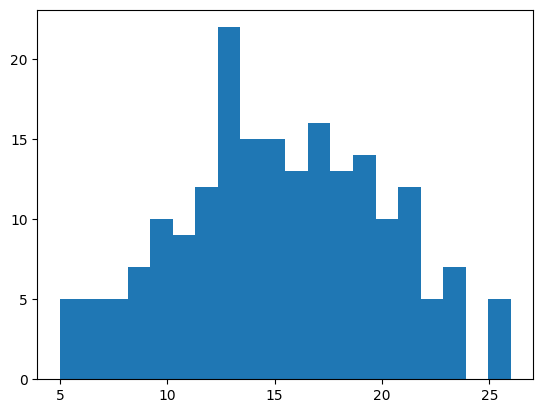

In [6]:
import matplotlib.pyplot as plt
plt.hist(coordination_num, bins=20)

In [ ]:
# plot the radial distribution function – look in the ASE docs for how to do this https://wiki.fysik.dtu.dk/ase/ase/neighborlist.html#ase.neighborlist.neighbor_list

(array([ 1.,  0.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         2.,  4., 10., 34., 41., 57., 44., 50., 46., 56., 45., 34., 18.,
        20., 13., 11.,  8.,  4.,  3.,  3.,  2.,  8.,  3.,  6.,  8.,  4.,
         2.]),
 array([ 49.66349425,  52.87763024,  56.09176624,  59.30590223,
         62.52003822,  65.73417422,  68.94831021,  72.1624462 ,
         75.3765822 ,  78.59071819,  81.80485418,  85.01899018,
         88.23312617,  91.44726216,  94.66139816,  97.87553415,
        101.08967014, 104.30380613, 107.51794213, 110.73207812,
        113.94621411, 117.16035011, 120.3744861 , 123.58862209,
        126.80275809, 130.01689408, 133.23103007, 136.44516607,
        139.65930206, 142.87343805, 146.08757405, 149.30171004,
        152.51584603, 155.72998203, 158.94411802, 162.15825401,
        165.37239001, 168.586526  , 171.80066199, 175.01479799,
        178.22893398]),
 <BarContainer object of 40 artists>)

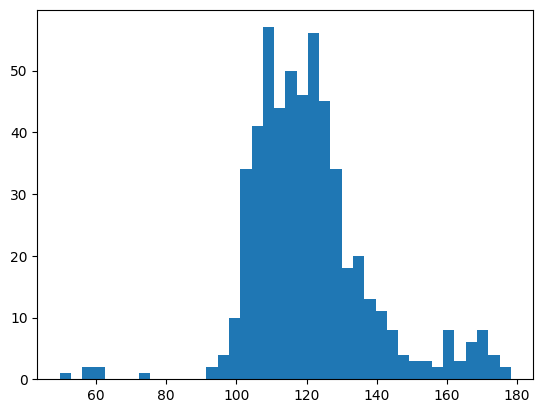

In [7]:
# plot the angular distribution function – look at the ASE docs for how to do this https://wiki.fysik.dtu.dk/ase/ase/geometry.html#ase.geometry.analysis.Analysis.get_angles

from ase.geometry.analysis import Analysis

analysis = Analysis(structure_0)
CCCAngles = analysis.get_angles('C', 'C', 'C', unique=True)
CCCAngleValues = analysis.get_values(CCCAngles)
    
plt.hist(CCCAngleValues, bins=40)

In [8]:
from quippy.descriptors import Descriptor

desc = Descriptor('soap cutoff=3.7 n_max=4 l_max=4 atom_sigma=0.5')
soaps = desc.calc(structure_0)['data']
soaps.shape

(200, 51)

In [9]:
# Lets write a function to do the above analysis for us.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def do_analysis(data, method, **kwargs):
    """
    Function to perform a dimensionality reduction analysis on the ACE
    descriptors.
    """

    # scale the data.
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # perform the analysis.
    if method == 'pca':
        pca = PCA(n_components=2)
        pca.fit(scaled_data)
        x_pca = pca.transform(scaled_data)
        print(scaled_data.shape)
        print(x_pca.shape)
        return x_pca
    
    else:
        print("Error: method not recognised.")
        return None

In [10]:
pca_data = do_analysis(soaps, 'pca')

(200, 51)
(200, 2)


In [ ]:
import chemiscope
properties = {
"PCA": {
    "target": "atom",
    "values": pca_data,
    "description": "PCA of per-atom representation of the structures",
    },
"coordination_num": {
    "target": "atom",
    "values": coordination_num,
    "description": "Coordination number of each atom",
    },
"local_energy": {
    "target": "atom",
    "values": structure_0.arrays["local_energies"],
    "description": "Local energies predicted with C-GAP-17",
    },
}

#properties_total = properties | frame_properties
ats_envs = chemiscope.all_atomic_environments([structure_0], cutoff=3.7)
chemiscope.show(frames = [structure_0], properties = properties, environments=ats_envs)

<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 200, 'names': ['C', 'C', 'C', 'C', 'C', 'C', 'C', '…

In [ ]:
# try again but for structures with higher densities

In [20]:
from quippy.descriptors import Descriptor

desc = Descriptor('soap cutoff=3.7 n_max=4 l_max=4 atom_sigma=0.5 average=T')
soaps = np.array([desc.calc(s)['data'] for s in structures])
soaps.shape
soaps=soaps.reshape(soaps.shape[0], -1)

In [21]:
pca_data = do_analysis(soaps, 'pca')

(546, 51)
(546, 2)


In [23]:
structure_0.info

{'anneal_T': 2000,
 'density': 1.0,
 'run_id': 1,
 'time': 210,
 'energy': -31510.6187621}

In [26]:
properties = {
"PCA": {
    "target": "structure",
    "values": pca_data,
    "description": "PCA of per-atom representation of the structures",
    },
"density": {
    "target": "structure",
    "values": [s.info['density'] for s in structures],
    "description": "Density of the structure",
    },
"total_energy": {
    "target": "structure",
    "values": [s.info['energy'] for s in structures],
    "description": "Total energies predicted with C-GAP-17",
    },
"anneal_T": {
    "target": "structure",
    "values": [s.info['anneal_T'] for s in structures],
    "description": "Annealing temperature of the structure",
    },
}

#properties_total = properties | frame_properties
chemiscope.show(frames = structures, properties = properties)

<ChemiscopeWidget(meta={'name': ' '}, structures=[{'size': 200, 'names': ['C', 'C', 'C', 'C', 'C', 'C', 'C', '…

---------

In [30]:
structures = load_dataset("structures_filt.xyz")
train, val, test = structures.random_split([0.8, 0.1, 0.1], seed=42)

In [73]:
train.arrays["local_energies"]

array([-157.9907571 , -157.26405376, -158.16396847, ..., -158.02091837,
       -158.02781939, -156.7560939 ])

In [75]:
train_energies = train.arrays["local_energies"]
val_energies = val.arrays["local_energies"]
test_energies = test.arrays["local_energies"]

In [67]:
desc = Descriptor('soap cutoff=3.7 n_max=4 l_max=4 atom_sigma=0.5')
soaps_train = np.array([desc.calc(s)['data'] for s in train])
soaps_val = np.array([desc.calc(s)['data'] for s in val])
soaps_test = np.array([desc.calc(s)['data'] for s in test])

In [76]:
soaps_train.shape, train_energies.shape

((436, 200, 51), (87200,))

In [77]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(soaps_train.reshape(-1, soaps_train.shape[-1]), train_energies)

LinearRegression()

In [78]:
train_pred = model.predict(soaps_train.reshape(-1, soaps_train.shape[-1]))
val_pred = model.predict(soaps_val.reshape(-1, soaps_val.shape[-1]))
test_pred = model.predict(soaps_test.reshape(-1, soaps_test.shape[-1]))

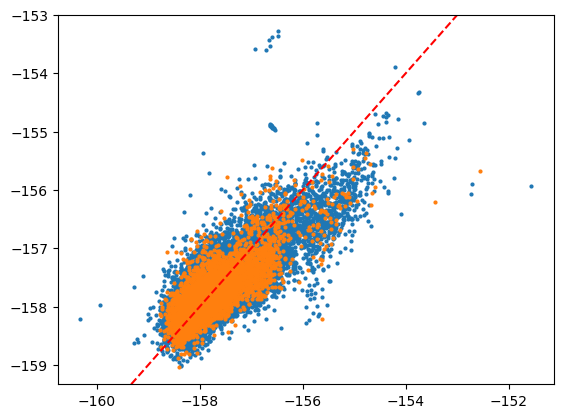

In [79]:
plt.scatter(train_energies, train_pred, s=4)
plt.scatter(test_energies, test_pred, s=4)
plt.axline((train_energies[0], train_energies[0]), slope=1, color='red', linestyle='--')

In [47]:
# evaluate the model's performance by evaluating the mean absolute error (MAE) and the root mean square error (RMSE) on the test set

In [96]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0)
model.fit(soaps_train.reshape(-1, soaps_train.shape[-1]), train_energies)

Ridge(alpha=0)

In [97]:
train_pred = model.predict(soaps_train.reshape(-1, soaps_train.shape[-1]))
val_pred = model.predict(soaps_val.reshape(-1, soaps_val.shape[-1]))
test_pred = model.predict(soaps_test.reshape(-1, soaps_test.shape[-1]))

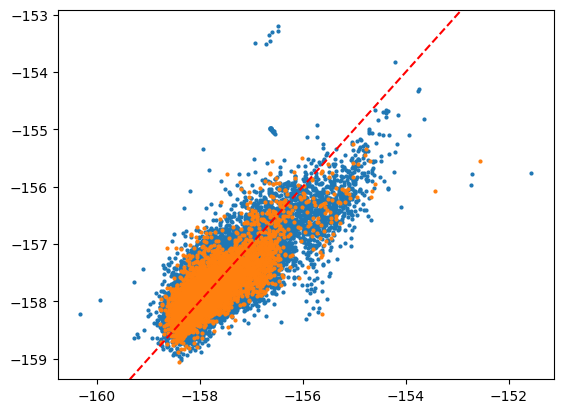

In [98]:
plt.scatter(train_energies, train_pred, s=4)
plt.scatter(test_energies, test_pred, s=4)
plt.axline((train_energies[0], train_energies[0]), slope=1, color='red', linestyle='--')

In [ ]:
# try the neural network model from scikit-learn
# implement a simple kernel model (or Gaussian Process Regression model) as detailed in the GPR review; you can also use kernel ridge regression from scikit-learn.